# 02. Feature Selection

## Purpose: Stroke Prediction

According to the NIH National Heart, Lung, and Blood Institute (HHLI):

>Strokes are caused by blocked blood flow to the brain (ischemic stroke) or sudden bleeding in the brain (hemorrhagic stroke). Many things raise your risk of stroke, and many of these can be changed to help prevent a stroke or prevent another stroke.

The aim of this analysis is to compare different models' accuracy when predicting a stroke based on key health factors.  

---

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.feature_selection import RFE

## 1. Pre-processing
**Read in cleaned data**

In [3]:
risk_factors = pd.read_csv('../data/processed/2020_BRFSS_stroke_risk_factors_clean.csv', index_col=0)
risk_factors

,age,sex,race,bmi_gt_25,coronary_heart_disease,diabetes,smoker,arthritis,heavy_alcohol,physical_activity,poor_mental_health,stroke
0,8.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,30.0,0.0
1,13.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,10.0,1.0,1.0,1.0,0.0,1.0,3.0,1.0,0.0,1.0,30.0,0.0
3,12.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
323684,4.0,1.0,8.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0
323685,6.0,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
323686,2.0,2.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
323687,13.0,2.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### 1.1 Baseline (Zero-R)
Dataset is imbalanced with 96% of instances with class 0.0

In [4]:
print('Total instatnces:')
print(len(risk_factors['stroke']), end='\n\n')

print('Values and counts of class stroke:') 
print(risk_factors['stroke'].value_counts(), end='\n\n')

print('Zero R of the dataset:')
print(risk_factors['stroke'].value_counts().max()/len(risk_factors['stroke']))

Total instatnces:
323689

Values and counts of class stroke:
0.0    311128
1.0     12561
Name: stroke, dtype: int64

Zero R of the dataset:
0.9611942327357432


<Axes: >

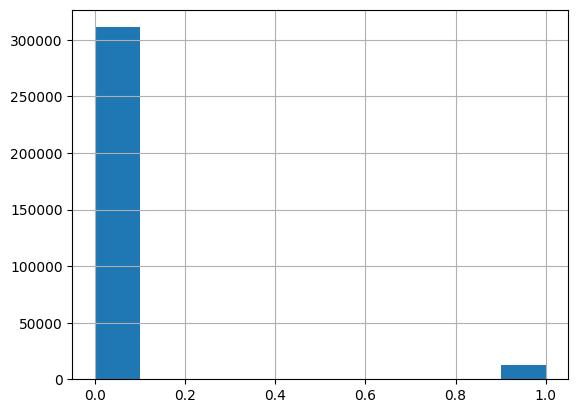

In [5]:
risk_factors['stroke'].hist()

### 1.2. Splitting into train and test set

In [6]:
from sklearn.model_selection import train_test_split
from collections import Counter

x_df = risk_factors.drop(columns=['stroke'])
y_df = risk_factors['stroke']

X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.3, random_state=100)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0.0: 217791, 1.0: 8791})
Testing target statistics: Counter({0.0: 93337, 1.0: 3770})


### 1.3. Comparing imbalanced and balanced dataset performance
Comparing the performance of the imbalanced and balanced dataset using a Random Forest algorithm
- Result: random under-sampling resulted in lower accuracy, but higher ROC_AUC score and F1 score so that method of balancing will be used to train the models

**Imbalanced dataset performance**

ROCAUC score: 0.5091505670007451
Accuracy score: 0.9577270433645361
F1 score: 0.04021510404489128


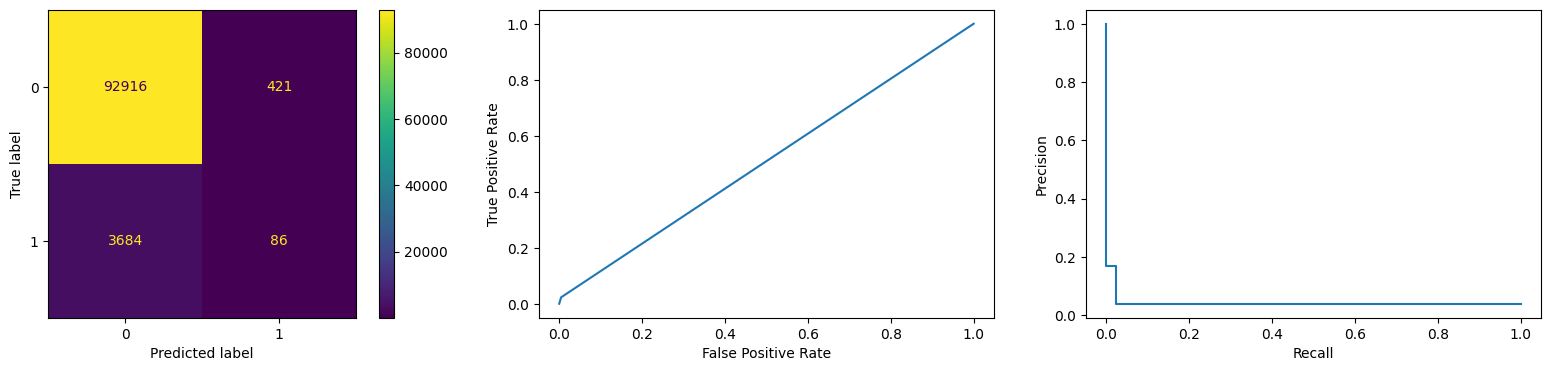

In [12]:
rfc = RandomForestClassifier()

# fit the predictor and target
rfc.fit(X_train, y_train)

# predict
rfc_predict_im = rfc.predict(X_test)

# check performance
print('ROCAUC score:',roc_auc_score(y_test, rfc_predict_im))
print('Accuracy score:',accuracy_score(y_test, rfc_predict_im))
print('F1 score:',f1_score(y_test, rfc_predict_im))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

cm_im = confusion_matrix(y_test, rfc_predict_im)
ConfusionMatrixDisplay(cm_im).plot(ax=ax1)

fpr_im, tpr_im, _ = roc_curve(y_test, rfc_predict_im)
roc_display_im = RocCurveDisplay(fpr=fpr_im, tpr=tpr_im).plot(ax=ax2)

prec_im, recall_im, _ = precision_recall_curve(y_test, rfc_predict_im)
pr_display_im = PrecisionRecallDisplay(precision=prec_im, recall=recall_im).plot(ax=ax3)


**Random under-sampling**

Perform under-sampling using python library `imblearn`

In [13]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

print('Training target statistics:', Counter(y_rus))
print('Testing target statistics:', Counter(y_test))

Training target statistics: Counter({0.0: 8791, 1.0: 8791})
Testing target statistics: Counter({0.0: 93337, 1.0: 3770})


Random under-sampling performance

ROCAUC score: 0.681410974220253
Accuracy score: 0.670137065299103
F1 score: 0.14035746873490418


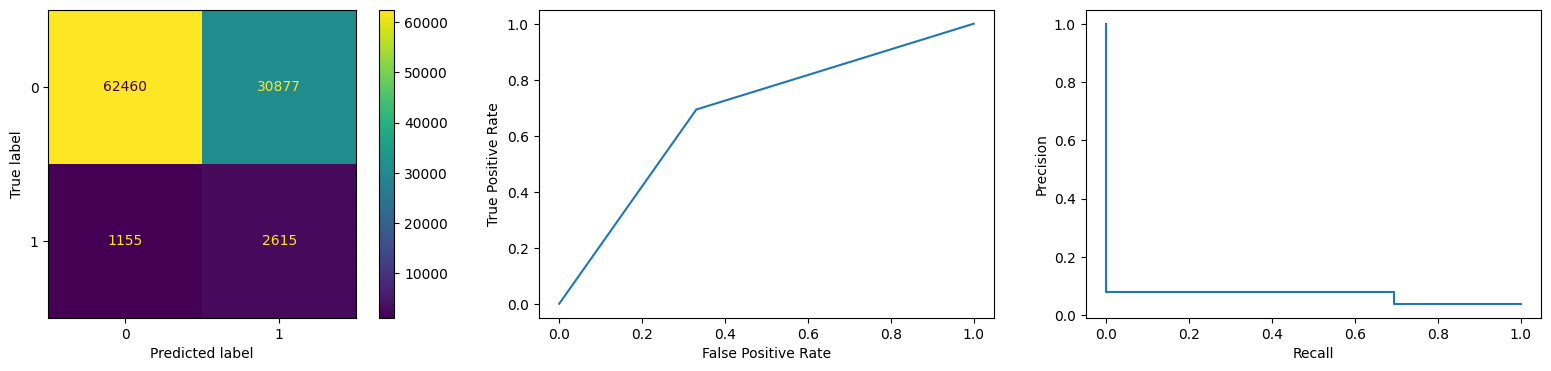

In [14]:
rfc = RandomForestClassifier()

# fit the predictor and target
rfc.fit(X_rus, y_rus)

# predict
rfc_predict_rus = rfc.predict(X_test)

# check performance
print('ROCAUC score:',roc_auc_score(y_test, rfc_predict_rus))
print('Accuracy score:',accuracy_score(y_test, rfc_predict_rus))
print('F1 score:',f1_score(y_test, rfc_predict_rus))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

cm_rus = confusion_matrix(y_test, rfc_predict_rus)
ConfusionMatrixDisplay(cm_rus).plot(ax=ax1)
# plt.show()

fpr_rus, tpr_rus, _ = roc_curve(y_test, rfc_predict_rus)
roc_display_im = RocCurveDisplay(fpr=fpr_rus, tpr=tpr_rus).plot(ax=ax2)

prec_rus, recall_rus, _ = precision_recall_curve(y_test, rfc_predict_rus)
pr_display_rus = PrecisionRecallDisplay(precision=prec_rus, recall=recall_rus).plot(ax=ax3)


### 1.4. Naive model performance
Comparing the following models with default settings when tested on the randomly under-sampled data:
1. Naive Bayes (Gaussian)
2. Decision Tree
3. Logistic Regressor
4. Multi-layer Perceptron (MLP)
5. Random Forest
6. AdaBoost


In [15]:
model_dict = {'Gaussian NB': GaussianNB(), 
              'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),  
              'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42), 
              'MLPClassifier': MLPClassifier(max_iter=1000, random_state=42),
              'RandomForestClassifier': RandomForestClassifier(random_state=42),
              'AdaBoostClassifier': AdaBoostClassifier(random_state=42)
              }

-----------------------------------
Gaussian NB
Accuracy: 0.7426344135850145
f1 score: 0.15795148247978436


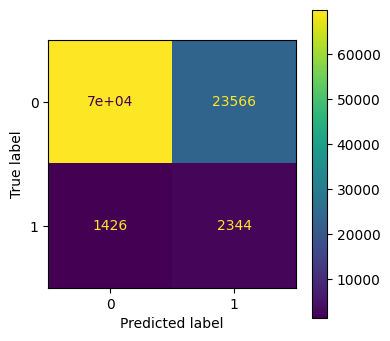

-----------------------------------
DecisionTreeClassifier
Accuracy: 0.6866549270392454
f1 score: 0.13236384374108925


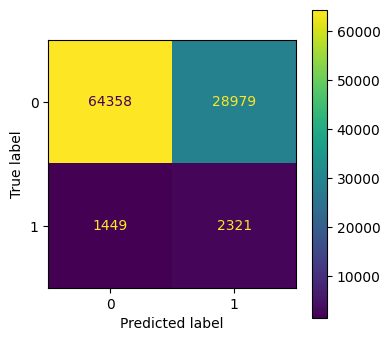

-----------------------------------
LogisticRegression
Accuracy: 0.6890852358738299
f1 score: 0.15333707234997196


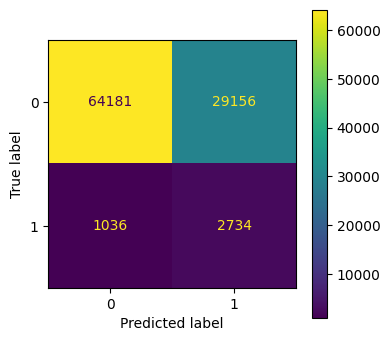

-----------------------------------
MLPClassifier
Accuracy: 0.6599524236151874
f1 score: 0.15115292665998303


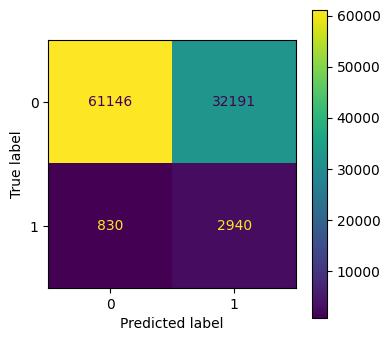

-----------------------------------
RandomForestClassifier
Accuracy: 0.6692205505267386
f1 score: 0.14002302481861262


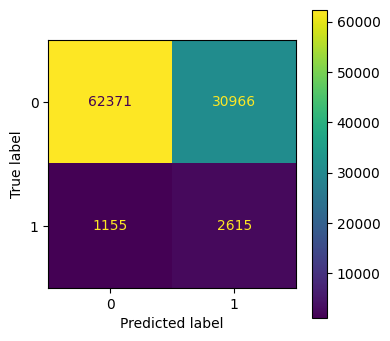

-----------------------------------
AdaBoostClassifier
Accuracy: 0.699764177659695
f1 score: 0.15661430761665077


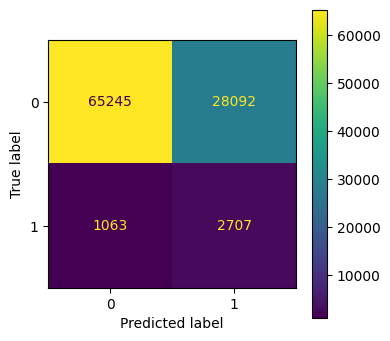

In [16]:
for model in model_dict:
  model_dict[model].fit(X_rus, y_rus)
  score = model_dict[model].score(X_test, y_test)
  pred = model_dict[model].predict(X_test)
  print('-'*35)
  print(model)
  print('Accuracy:', score)
  print('f1 score:', f1_score(y_test, pred))
  fig, ax = plt.subplots(figsize=(4,4))
  ConfusionMatrixDisplay(confusion_matrix(y_test, pred)).plot(ax=ax)
  plt.show()

- All of the f1 scores are pretty low
- Accuracy is ok but could be improved

## 2. Feature Selection

### 2.1. Tree model feature importance
- Each tree places higher importance on similar features 

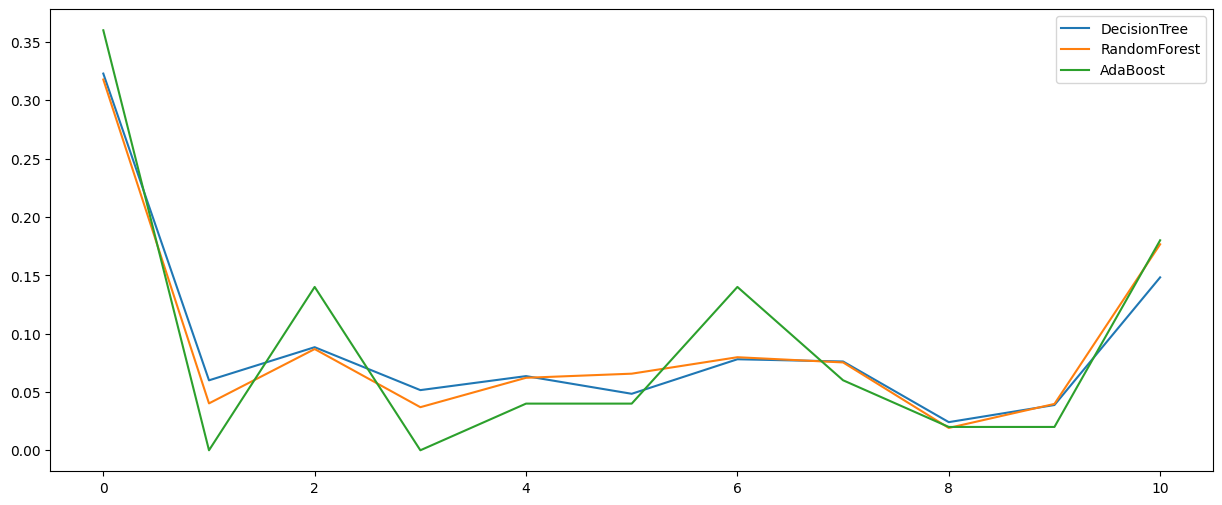

In [17]:
plt.figure(figsize=(15,6))
plt.plot(model_dict['DecisionTreeClassifier'].feature_importances_, label='DecisionTree')
plt.plot(model_dict['RandomForestClassifier'].feature_importances_, label='RandomForest')
plt.plot(model_dict['AdaBoostClassifier'].feature_importances_, label='AdaBoost')
plt.legend()
plt.show()

### 2.2. Recursive feature elimination (RFE)

- Using RFE to recursively remove features and building the model with the ones that remain
- Model accuracy is used to determine which features or feature combinations have better predictive power

In [19]:
from sklearn.feature_selection import RFE

decision_tree = model_dict['DecisionTreeClassifier']
random_forest = model_dict['RandomForestClassifier']
adaboost = model_dict['AdaBoostClassifier']

RFE_dt = RFE(decision_tree, n_features_to_select=7)
RFE_rf = RFE(random_forest, n_features_to_select=7)
RFE_ab = RFE(adaboost, n_features_to_select=7)

RFE_dt.fit(X_rus, y_rus)
RFE_rf.fit(X_rus, y_rus)
RFE_ab.fit(X_rus, y_rus)

RFE(estimator=AdaBoostClassifier(random_state=42), n_features_to_select=7)

RFE rankings

In [21]:
dt_rank = RFE_dt.ranking_
rf_rank = RFE_rf.ranking_
ab_rank = RFE_ab.ranking_

RFE_rank = pd.DataFrame({'DecisionTree': dt_rank, 
                     'RandomForest': rf_rank,
                     'AdaBoostClassifier': ab_rank}).set_index(X_rus.columns)
RFE_rank

,DecisionTree,RandomForest,AdaBoostClassifier
age,1,1,1
sex,1,3,5
race,1,1,1
bmi_gt_25,3,4,4
coronary_heart_disease,1,1,1
diabetes,2,1,1
smoker,1,1,1
arthritis,1,1,1
heavy_alcohol,5,5,3
physical_activity,4,2,2


- Rank of 1 = most important feature, so features that were ranked with 1 across all classifiers will be selected
- Other features that contain at least one 1 rank will be further investigated

In [23]:
include = []
may_include = []

for i in RFE_rank.index:
  if RFE_rank.loc[i, :].sum() == 3:
    include.append(i)
  elif 1 in RFE_rank.loc[i, :].values:
    may_include.append(i)
    
print('Include:', include)
print('May include:', may_include)

Include: ['age', 'race', 'coronary_heart_disease', 'smoker', 'arthritis', 'poor_mental_health']
May include: ['sex', 'diabetes']


**Checking correlation of features in original dataset**
- Some of the features in `include` (age, coronary_heart_disease, arthritis, diabetes) do have a slightly higher correlation to stroke

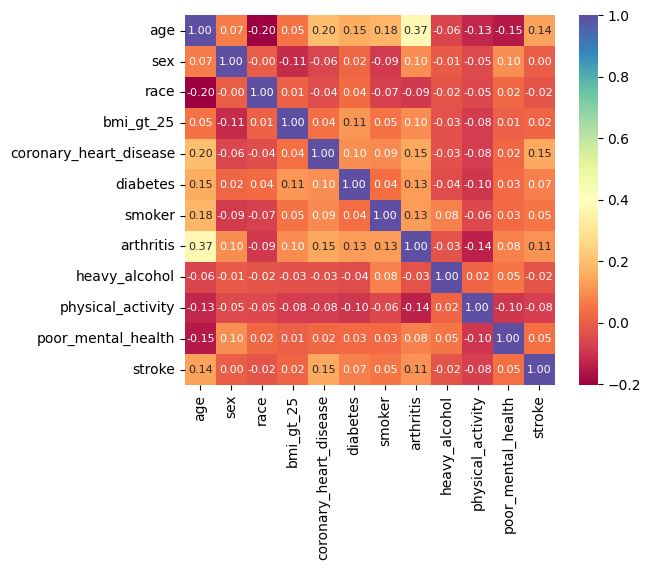

In [24]:
corr_mat = risk_factors.corr()
heatmap = sns.heatmap(corr_mat, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 8}, 
                 yticklabels=risk_factors.columns, 
                 xticklabels=risk_factors.columns, 
                 cmap="Spectral")
plt.show()

**VS correlation of RFE features**

Include: ['age', 'race', 'coronary_heart_disease', 'smoker', 'arthritis', 'poor_mental_health']
May include: ['sex', 'diabetes']


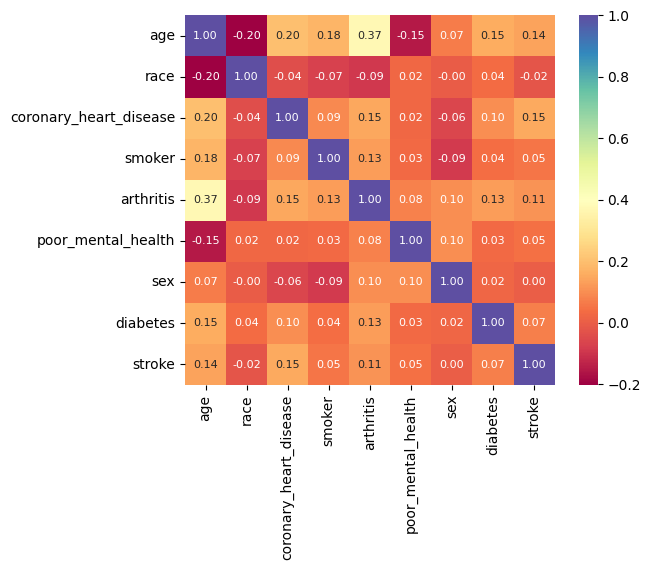

In [26]:
select_features = risk_factors[include + may_include + ['stroke']]
g = sns.heatmap(select_features.corr(),
                cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 8}, 
                #  yticklabels=risk_factors.columns, 
                #  xticklabels=risk_factors.columns, 
                 cmap="Spectral")

print('Include:', include)
print('May include:', may_include)

plt.show()

**Distribution of class stroke**

`include` features

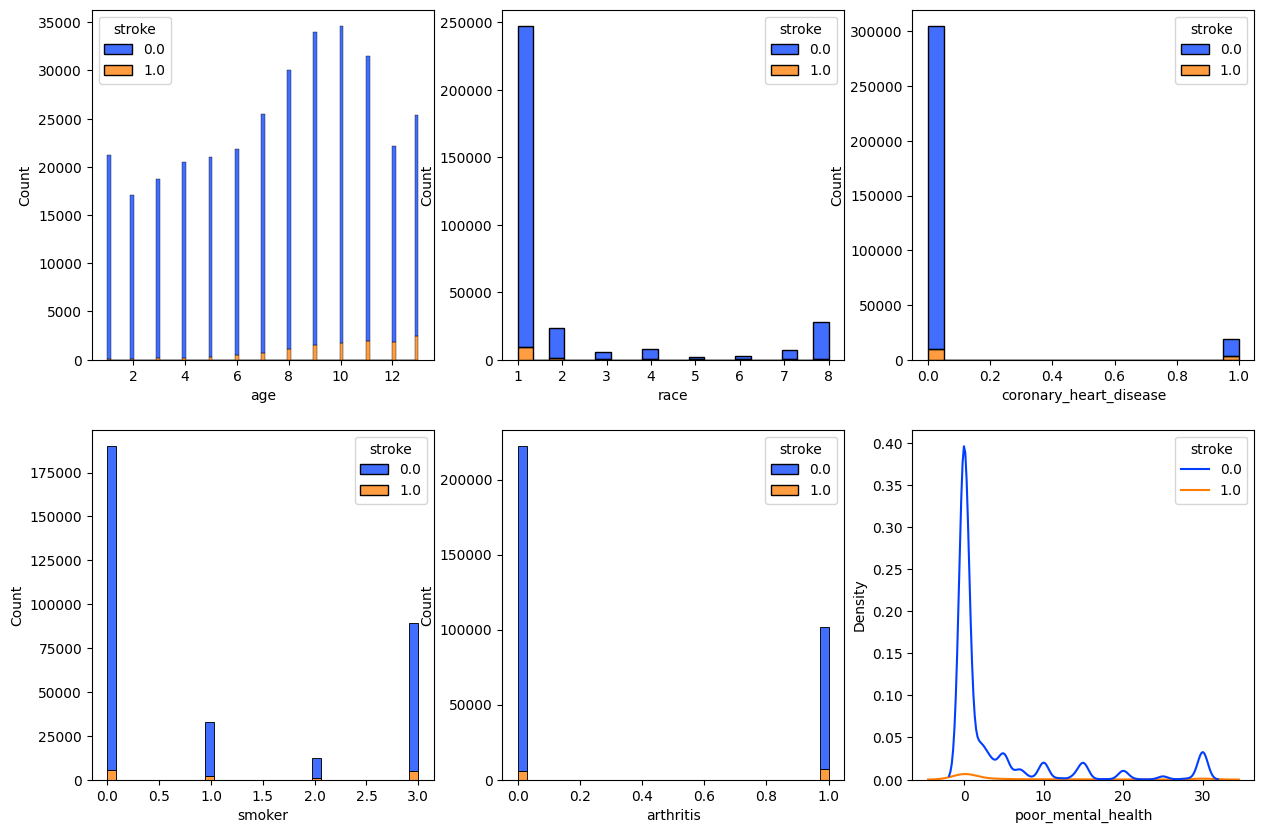

In [28]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
i = 0
for col in include:
    if col=='poor_mental_health':
        sns.kdeplot(data=risk_factors, x=col, hue='stroke', ax=ax[i//3, i%3], palette='bright')
    else:
        sns.histplot(data=risk_factors, x=col, hue='stroke', ax=ax[i//3, i%3], multiple="stack", palette='bright')
    i+=1
plt.show()

`may_include` features

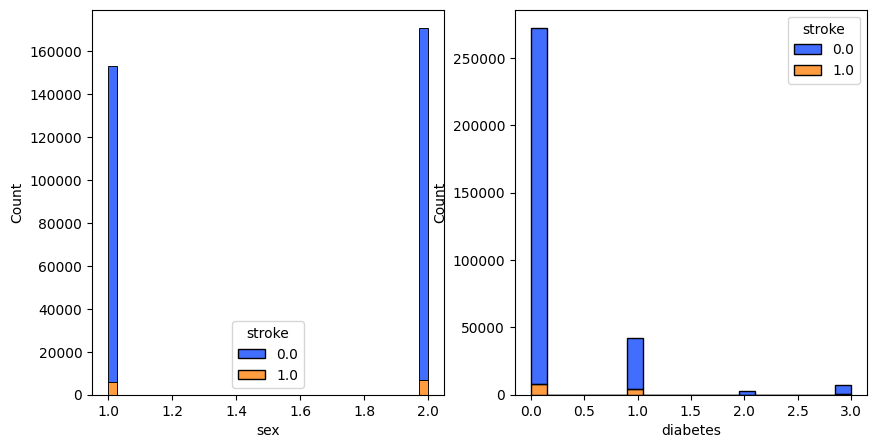

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
i = 0
for col in may_include:
    if col=='poor_mental_health':
        sns.kdeplot(data=risk_factors, x=col, hue='stroke', ax=ax[i], palette='bright')
    else:
        sns.histplot(data=risk_factors, x=col, hue='stroke', ax=ax[i], multiple="stack", palette='bright')
    i+=1
plt.show()

- Although `race` is in the `include` features, it is the selected feature with the lowest correlation to stroke
  - It will still be included since the RFE selected it
- In the `may_include` features, `sex` has a correlation of 0 so I will not be inclduing it. `diabetes` has a higher correlation to stroke so I will include it as well

In [44]:
selected_features = ['age', 'race', 'coronary_heart_disease', 'smoker', 
                     'arthritis', 'poor_mental_health', 'diabetes']

### 1.3. Scaling
MinMax scaling the data in the range of 0-1 to prepare for modeling
- Train-test splits and under-sampling will be performed in the modeling notebook

In [48]:
def minmax_scaling(dataframe):
  df = dataframe.copy()
  for col in df.columns:
    df[col] = (df[col] - df[col].min())
    df[col] = df[col] / df[col].max()
  return df

In [49]:
scaled_df = minmax_scaling(risk_factors)
scaled_df

,age,sex,race,bmi_gt_25,coronary_heart_disease,diabetes,smoker,arthritis,heavy_alcohol,physical_activity,poor_mental_health,stroke
0,0.583333,1.0,0.0,0.0,0.0,0.333333,0.333333,1.0,0.0,1.0,1.000000,0.0
1,1.000000,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.000000,1.0
2,0.750000,0.0,0.0,1.0,0.0,0.333333,1.000000,1.0,0.0,1.0,1.000000,0.0
3,0.916667,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
4,0.333333,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
323684,0.250000,0.0,1.0,1.0,0.0,0.000000,1.000000,0.0,0.0,1.0,0.000000,0.0
323685,0.416667,1.0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.0
323686,0.083333,1.0,1.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
323687,1.000000,1.0,1.0,1.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.0


In [51]:
scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,323689.0,0.545696,0.297757,0.0,0.333333,0.583333,0.75,1.0
sex,323689.0,0.527401,0.499249,0.0,0.000000,1.000000,1.00,1.0
race,323689.0,0.139612,0.310059,0.0,0.000000,0.000000,0.00,1.0
bmi_gt_25,323689.0,0.680073,0.466449,0.0,0.000000,1.000000,1.00,1.0
coronary_heart_disease,323689.0,0.058448,0.234589,0.0,0.000000,0.000000,0.00,1.0
diabetes,323689.0,0.070139,0.185961,0.0,0.000000,0.000000,0.00,1.0
smoker,323689.0,0.333445,0.437656,0.0,0.000000,0.000000,1.00,1.0
arthritis,323689.0,0.313610,0.463960,0.0,0.000000,0.000000,1.00,1.0
heavy_alcohol,323689.0,0.067781,0.251370,0.0,0.000000,0.000000,0.00,1.0
physical_activity,323689.0,0.771132,0.420105,0.0,1.000000,1.000000,1.00,1.0


In [50]:
scaled_df.to_csv('../data/processed/2020_BRFSS_stroke_risk_factors_scaled.csv')